In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import sklearn

plt.style.use('seaborn')
sns.set(font_scale=2.5) # 이 두줄은 본 필자가 항상 쓰는 방법입니다. matplotlib 의 기본 scheme 말고 seaborn scheme 을 세팅하고, 일일이 graph 의 font size 를 지정할 필요 없이 seaborn 의 font_scale 을 사용하면 편합니다.
import missingno as msno

#ignore warnings
import warnings
warnings.filterwarnings('ignore') # 워닝 메세지를 생략해 줍니다. 차후 버전관리를 위해 필요한 정보라고 생각하시면 주석처리 하시면 됩니다.

%matplotlib inline

Using TensorFlow backend.


In [5]:
os.listdir("/Users/Owner/input")

['gender_submission.csv', 'test.csv', 'train.csv']

In [13]:
df_train = pd.read_csv('/Users/Owner/input/train.csv')
df_test = pd.read_csv('/Users/Owner/input/test.csv')
df_submit = pd.read_csv('/Users/Owner/input/gender_submission.csv')

In [14]:
df_train.columns


Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [10]:
df_train.drop(['PassengerId', 'Name', 'Ticket', 'Cabin','Embarked'], axis=1, inplace=True)

In [15]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [16]:
df_train['Initial']= df_train.Name.str.extract('([A-Za-z]+)\.') #lets extract the Salutations
df_test['Initial']= df_test.Name.str.extract('([A-Za-z]+)\.') #lets extract the Salutations

In [17]:
pd.crosstab(df_train['Initial'], df_train['Sex']).T.style.background_gradient(cmap='summer_r') #Checking the Initials with the Sex

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


In [18]:
df_train['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)

df_test['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)

In [19]:
df_train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
Initial,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,34.703125
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,43.937188
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,24.939822
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,45.420603
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,19.102778


In [20]:
df_train["Initial"].isnull().sum()

0

In [21]:
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mr'),'Age'] = 33
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mrs'),'Age'] = 36
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Master'),'Age'] = 5
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Miss'),'Age'] = 22
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Other'),'Age'] = 46

df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mr'),'Age'] = 33
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mrs'),'Age'] = 36
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Master'),'Age'] = 5
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Miss'),'Age'] = 22
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Other'),'Age'] = 46

In [22]:
def category_age(x):
    if x < 10:
        return 0
    elif x < 20:
        return 1
    elif x < 30:
        return 2
    elif x < 40:
        return 3
    elif x < 50:
        return 4
    elif x < 60:
        return 5
    elif x < 70:
        return 6
    else:
        return 7    
    
df_train['Age_cat'] = df_train['Age'].apply(category_age)
df_test['Age_cat'] = df_test['Age'].apply(category_age)

In [23]:
df_train.groupby('Fare').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Age_cat
Fare,,,,,,,
0.0000,516.40,0.066667,1.933333,34.000000,0.00,0.000000,2.933333
4.0125,379.00,0.000000,3.000000,20.000000,0.00,0.000000,2.000000
5.0000,873.00,0.000000,1.000000,33.000000,0.00,0.000000,3.000000
6.2375,327.00,0.000000,3.000000,61.000000,0.00,0.000000,6.000000
6.4375,844.00,0.000000,3.000000,34.500000,0.00,0.000000,3.000000
...,...,...,...,...,...,...,...
227.5250,589.25,0.750000,1.000000,32.750000,0.25,0.000000,2.750000
247.5208,209.50,0.500000,1.000000,37.000000,0.00,1.000000,3.500000
262.3750,527.50,1.000000,1.000000,19.500000,2.00,2.000000,1.500000


In [25]:
def category_fare(x):
    if x < 50:
        return 0
    elif x < 100:
        return 1
    elif x < 150:
        return 2
    elif x < 200:
        return 3
    elif x < 250:
        return 4
    elif x < 300:
        return 5
    elif x < 350:
        return 6
    elif x < 400:
        return 6
    elif x < 450:
        return 6
    elif x < 500:
        return 6
    else:
        return 7    
    
df_train['Fare_cat'] = df_train['Fare'].apply(category_fare)
df_test['Fare_cat'] = df_test['Fare'].apply(category_fare)

In [26]:
df_train['Initial'] = df_train['Initial'].map({'Master': 0, 'Miss': 1, 'Mr': 2, 'Mrs': 3, 'Other': 4})
df_test['Initial'] = df_test['Initial'].map({'Master': 0, 'Miss': 1, 'Mr': 2, 'Mrs': 3, 'Other': 4})

In [27]:
df_train['Sex'] = df_train['Sex'].map({'female': 0, 'male': 1})
df_test['Sex'] = df_test['Sex'].map({'female': 0, 'male': 1})

In [66]:
df_train.head()

,Survived,Pclass,Sex,Initial,Age_cat,Fare_cat,FamilySize
0,0,3,1,2,2,0,1
1,1,1,0,3,3,1,1
2,1,3,0,1,2,0,0
3,1,1,0,3,3,1,1
4,0,3,1,2,3,0,0


In [30]:
df_train.sum('SibSP'+'Parch').max()

ValueError: No axis named SibSPParch for object type <class 'pandas.core.frame.DataFrame'>

In [32]:
dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

NameError: name 'dataset' is not defined

In [92]:
df_test['FamilySize']=df_train['FamilySize']

In [34]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,Age_cat,Fare_cat,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S,2,2,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C,3,3,1,1
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,2,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S,3,3,1,1
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S,2,3,0,0


In [35]:
df_train.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Embarked', 'Age', 'Fare'], axis=1, inplace=True)
df_test.drop(['PassengerId', 'Name',  'SibSp', 'Parch', 'Ticket', 'Cabin', 'Embarked', 'Age', 'Fare'], axis=1, inplace=True)

In [36]:
df_train.head()

,Survived,Pclass,Sex,Initial,Age_cat,Fare_cat,FamilySize
0,0,3,1,2,2,0,1
1,1,1,0,3,3,1,1
2,1,3,0,1,2,0,0
3,1,1,0,3,3,1,1
4,0,3,1,2,3,0,0


In [93]:
df_test.head()

,Pclass,Sex,Initial,Age_cat,Fare_cat,FamilySize
0,3,1,2,3,0,1
1,3,0,3,4,0,1
2,2,1,2,6,0,0
3,3,1,2,2,0,1
4,3,0,3,2,0,0


In [94]:
#importing all the required ML packages
from sklearn.ensemble import RandomForestClassifier # 유명한 randomforestclassfier 입니다. 
from sklearn import metrics # 모델의 평가를 위해서 씁니다
from sklearn.model_selection import train_test_split # traning set을 쉽게 나눠주는 함수입니다.

In [95]:
X_train = df_train.drop('Survived', axis=1).values
target_label = df_train['Survived'].values
X_test = df_test.values

In [96]:
X_tr, X_vld, y_tr, y_vld = train_test_split(X_train, target_label, test_size=0.2, random_state=2018)

In [97]:
y_tr.shape, y_vld.shape

((712,), (179,))

In [98]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.optimizers import Adam, SGD

In [117]:
nn_model = Sequential()
nn_model.add(Dense(6,activation='relu',input_shape=(6,)))
nn_model.add(Dropout(0.2))
nn_model.add(Dense(6,activation='relu'))

nn_model.add(Dense(6,activation='relu'))

nn_model.add(Dense(6,activation='relu'))
nn_model.add(Dropout(0.2))
nn_model.add(Dense(1,activation='sigmoid'))

Loss = 'binary_crossentropy'
nn_model.compile(loss=Loss,optimizer=Adam(),metrics=['accuracy'])
nn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_58 (Dense)             (None, 6)                 42        
_________________________________________________________________
dropout_43 (Dropout)         (None, 6)                 0         
_________________________________________________________________
dense_59 (Dense)             (None, 6)                 42        
_________________________________________________________________
dropout_44 (Dropout)         (None, 6)                 0         
_________________________________________________________________
dense_60 (Dense)             (None, 6)                 42        
_________________________________________________________________
dropout_45 (Dropout)         (None, 6)                 0         
_________________________________________________________________
dense_61 (Dense)             (None, 6)                 42        
__________

In [118]:
history = nn_model.fit(X_tr,y_tr,
                    batch_size=6,
                    epochs=200,
                    validation_data=(X_vld, y_vld),
                    verbose=1)

Train on 712 samples, validate on 179 samples
Epoch 1/200
712/712 [==============================] - 4s 5ms/step - loss: 0.9305 - acc: 0.4396 - val_loss: 0.7625 - val_acc: 0.4637
Epoch 2/200
712/712 [==============================] - 1s 717us/step - loss: 0.7068 - acc: 0.5351 - val_loss: 0.7045 - val_acc: 0.5642
Epoch 3/200
712/712 [==============================] - 1s 763us/step - loss: 0.6931 - acc: 0.6096 - val_loss: 0.6854 - val_acc: 0.5922
Epoch 4/200
712/712 [==============================] - 1s 718us/step - loss: 0.6800 - acc: 0.6152 - val_loss: 0.6758 - val_acc: 0.5922
Epoch 5/200
712/712 [==============================] - 1s 789us/step - loss: 0.6693 - acc: 0.6292 - val_loss: 0.6683 - val_acc: 0.6089
Epoch 6/200
712/712 [==============================] - 0s 702us/step - loss: 0.6661 - acc: 0.6264 - val_loss: 0.6626 - val_acc: 0.6201
Epoch 7/200
712/712 [==============================] - 1s 779us/step - loss: 0.6614 - acc: 0.6194 - val_loss: 0.6536 - val_acc: 0.6257
Epoch 8/200

Epoch 61/200
712/712 [==============================] - 1s 713us/step - loss: 0.5295 - acc: 0.7654 - val_loss: 0.4610 - val_acc: 0.7989
Epoch 62/200
712/712 [==============================] - 1s 789us/step - loss: 0.5283 - acc: 0.7556 - val_loss: 0.4494 - val_acc: 0.7989
Epoch 63/200
712/712 [==============================] - 1s 825us/step - loss: 0.5316 - acc: 0.7584 - val_loss: 0.4568 - val_acc: 0.7989
Epoch 64/200
712/712 [==============================] - 1s 764us/step - loss: 0.5358 - acc: 0.7542 - val_loss: 0.4571 - val_acc: 0.7989
Epoch 65/200
712/712 [==============================] - 0s 678us/step - loss: 0.5629 - acc: 0.7458 - val_loss: 0.4724 - val_acc: 0.7933
Epoch 66/200
712/712 [==============================] - 1s 743us/step - loss: 0.5346 - acc: 0.7444 - val_loss: 0.4625 - val_acc: 0.7989
Epoch 67/200
712/712 [==============================] - 1s 742us/step - loss: 0.5228 - acc: 0.7556 - val_loss: 0.4609 - val_acc: 0.7989
Epoch 68/200
712/712 [==========================

712/712 [==============================] - 1s 904us/step - loss: 0.5191 - acc: 0.7753 - val_loss: 0.4412 - val_acc: 0.8101
Epoch 122/200
712/712 [==============================] - 1s 1ms/step - loss: 0.4976 - acc: 0.7781 - val_loss: 0.4383 - val_acc: 0.8156
Epoch 123/200
712/712 [==============================] - 1s 835us/step - loss: 0.4937 - acc: 0.7851 - val_loss: 0.4327 - val_acc: 0.8212
Epoch 124/200
712/712 [==============================] - 1s 1ms/step - loss: 0.4911 - acc: 0.7823 - val_loss: 0.4338 - val_acc: 0.8212
Epoch 125/200
712/712 [==============================] - 1s 860us/step - loss: 0.4960 - acc: 0.7640 - val_loss: 0.4396 - val_acc: 0.8156
Epoch 126/200
712/712 [==============================] - 1s 985us/step - loss: 0.4628 - acc: 0.8076 - val_loss: 0.4255 - val_acc: 0.8212
Epoch 127/200
712/712 [==============================] - 1s 873us/step - loss: 0.5153 - acc: 0.7781 - val_loss: 0.4274 - val_acc: 0.8212
Epoch 128/200
712/712 [==============================] - 1s

712/712 [==============================] - 1s 881us/step - loss: 0.5093 - acc: 0.7767 - val_loss: 0.4374 - val_acc: 0.8212
Epoch 182/200
712/712 [==============================] - 1s 888us/step - loss: 0.4891 - acc: 0.7851 - val_loss: 0.4213 - val_acc: 0.8156
Epoch 183/200
712/712 [==============================] - 1s 803us/step - loss: 0.4825 - acc: 0.7907 - val_loss: 0.4240 - val_acc: 0.8268
Epoch 184/200
712/712 [==============================] - 1s 737us/step - loss: 0.5037 - acc: 0.7879 - val_loss: 0.4138 - val_acc: 0.8268
Epoch 185/200
712/712 [==============================] - 1s 734us/step - loss: 0.4669 - acc: 0.8076 - val_loss: 0.4254 - val_acc: 0.8156
Epoch 186/200
712/712 [==============================] - 1s 705us/step - loss: 0.4854 - acc: 0.7865 - val_loss: 0.4238 - val_acc: 0.8156
Epoch 187/200
712/712 [==============================] - 1s 789us/step - loss: 0.4852 - acc: 0.7767 - val_loss: 0.4186 - val_acc: 0.8268
Epoch 188/200
712/712 [==============================] 

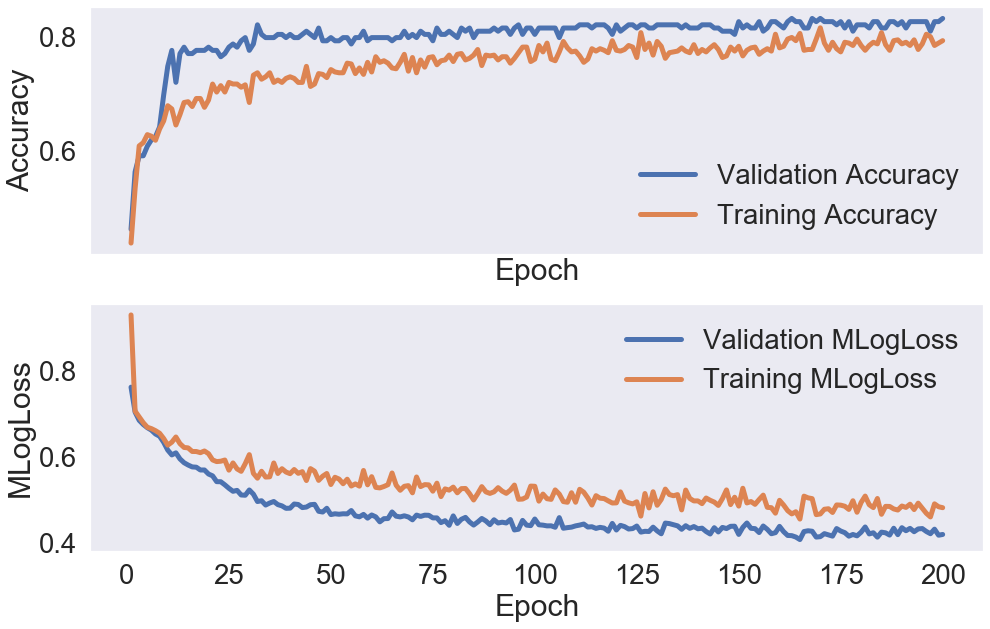

In [119]:
hists = [history]
hist_df = pd.concat([pd.DataFrame(hist.history) for hist in hists], sort=True)
hist_df.index = np.arange(1, len(hist_df)+1)
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
axs[0].plot(hist_df.val_acc, lw=5, label='Validation Accuracy')
axs[0].plot(hist_df.acc, lw=5, label='Training Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].grid()
axs[0].legend(loc=0)
axs[1].plot(hist_df.val_loss, lw=5, label='Validation MLogLoss')
axs[1].plot(hist_df.loss, lw=5, label='Training MLogLoss')
axs[1].set_ylabel('MLogLoss')
axs[1].set_xlabel('Epoch')
axs[1].grid()
axs[1].legend(loc=0)
fig.savefig('hist.png', dpi=300)
plt.show();

In [83]:
submission = pd.read_csv('/Users/Owner/input/sample_submission.csv')
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [73]:
prediction = model.predict(X_test)
submission['Survived'] = prediction

NameError: name 'model' is not defined

In [61]:
submission.to_csv('my_first_submission8.csv', index=False)

In [120]:
submission = pd.read_csv('/Users/Owner/input/sample_submission.csv')
prediction = nn_model.predict(X_test)
prediction = prediction > 0.5
prediction = prediction.astype(np.int)
prediction = prediction.T[0]
prediction.shape

(418,)

In [88]:
print(X_test.shape)

(418, 5)


In [89]:
print(X_test[0].shape)

(5,)


In [121]:
submission['Survived'] = prediction
submission.to_csv('my_nn_submission2.csv', index=False)

In [110]:
model = RandomForestClassifier()
model.fit(X_tr, y_tr)
prediction = model.predict(X_vld)

In [111]:
print('총 {}명 중 {:.2f}% 정확도로 생존을 맞춤'.format(y_vld.shape[0], 100 * metrics.accuracy_score(prediction, y_vld)))

총 179명 중 82.68% 정확도로 생존을 맞춤


In [112]:
from pandas import Series

feature_importance = model.feature_importances_
Series_feat_imp = Series(feature_importance, index=df_test.columns)

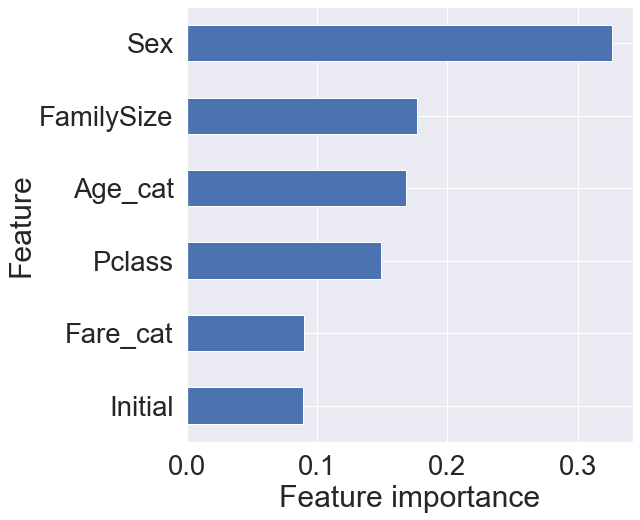

In [113]:
plt.figure(figsize=(8, 8))
Series_feat_imp.sort_values(ascending=True).plot.barh()
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()